In [1]:
%cd ..
%pwd

/home/mszmelcz/Documents/K2/generative_models/synesthesian_dreams


'/home/mszmelcz/Documents/K2/generative_models/synesthesian_dreams'

In [2]:
import librosa
import librosa.display
import sklearn
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
audio_path = '/home/mszmelcz/Music/Chalk_CIty_-__I_Don_t_Even__Need_Your_Love.mp3'
x , sr = librosa.load(audio_path, sr=None)
print(type(x), type(sr))
print(x.shape, sr)

/home/mszmelcz/anaconda3/envs/pytorch/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


<class 'numpy.ndarray'> <class 'int'>
(9053905,) 44100


(8977920,)


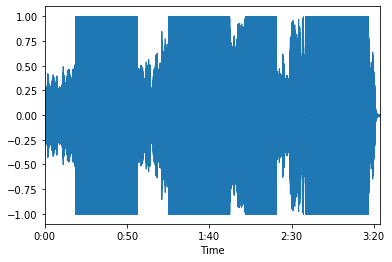

In [4]:
song, _ = librosa.effects.trim(x)
librosa.display.waveplot(song, sr=sr);
print(song.shape)

In [11]:
from models.dcgan import DCGAN
from models.msggan import MSGGAN

# model_path = "./experiments/dcgan_spectral2/checkpoints/170.pt"

# dcgan = DCGAN()
# dir(dcgan)
# dcgan.load_netG_for_eval(model_path)

model_path = "./experiments/base_msggan_256_nz64/checkpoints/40.pt"

msggan = MSGGAN()
msggan.load_netG_for_eval(model_path)
dir(msggan)

gan = msggan

NZ 64
{'add_noise': True,
 'beta1': 0.5,
 'beta2': 0.999,
 'depth': 7,
 'img_size': 64,
 'loss_criterion': 'BCE',
 'lr_D': 0.0002,
 'lr_G': 0.0001,
 'nc': 3,
 'ndf': 64,
 'nz': 64,
 'use_label_smoothing': False,
 'use_schedulerD': False,
 'use_schedulerG': False,
 'use_spectral_norm_D': False,
 'use_spectral_norm_G': False}


In [12]:
song2 = np.hstack((song, song))

In [15]:
X = librosa.stft(song)
print(X.shape)
Xdb = librosa.amplitude_to_db(abs(X))
idxs = np.random.choice(Xdb.shape[1], 64)
selected = Xdb[:, idxs]
selected_standardized = (selected - selected.mean(1)[:, None]) / selected.std(1)[:, None]
print(selected_standardized.shape)

(1025, 17536)
(1025, 64)


In [16]:
# features = selected_standardized[:]
features = selected_standardized
features = features.reshape(-1, 64)
latent_code = torch.from_numpy(features)
imgs = gan.netG(latent_code.cuda()).detach().cpu().numpy().squeeze()
plt.imshow(np.transpose(imgs[5], (1,2,0)))

RuntimeError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 7.79 GiB total capacity; 74.03 MiB already allocated; 56.31 MiB free; 19.97 MiB cached)

In [ ]:
import torchvision.utils as vutils

def plot_fake_transition(model, sample_size=64, nz=100, step=0.5):
    
    noise_seed = np.random.normal(0, 1, (1, nz, 1, 1))

    noise = np.repeat(noise_seed, sample_size, axis=0)
    for i in range(1, sample_size):
        n = np.random.randint(-1, 2, (nz, 1, 1))
        #noise[i] += noise[i-1] * n * step
        noise[i] += n * step
        #noise[i] *= np.power(step, i)
        
    latent_code = torch.from_numpy(noise)
    latent_code = latent_code.type(torch.FloatTensor)
    print(latent_code.type())
    imgs = dcgan.netG(latent_code.cuda()).detach().cpu()
    
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=int(np.sqrt(sample_size)), padding=5, normalize=True), (1,2,0)))
    plt.show()

In [ ]:
plot_fake_transition(dcgan)

In [ ]:
import cv2

# frames_per_sec = 3.5 * 60 / 1025
frames_per_sec = 5
print(frames_per_sec)

img_size = (64, 64)

img_list = [ np.transpose(i,(1,2,0)) for i in imgs ]
print(img_list[0].shape)
    
out = cv2.VideoWriter('vis.avi',cv2.VideoWriter_fourcc(*'DIVX'), frames_per_sec, img_size)

for img in img_list:
    im = (img - img.min()) / (img.max() - img.min())
    im = np.uint8(im * 255)
#     print(img_list[i].depth)
    out.write(im)
out.release()

In [ ]:
nz = 100
print(features.shape)
idxs = np.random.randint(low=0, high=3792384, size=100)
features = x[idxs].reshape(1,-1,1,1) * 100
print(features.mean())
latent_code = torch.from_numpy(features)


netG = get_netG(model_path)

img = netG(latent_code).detach().numpy().squeeze()

plt.imshow(np.transpose(img, (1,2,0)))

In [ ]:
import IPython.display as ipd
ipd.Audio(audio_path)

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [ ]:
print(sr)

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
print(Xdb.shape)
idxs = np.random.choice(Xdb.shape[1], 100)
selected = Xdb[:, idxs]
selected_standardized = (selected - selected.mean(1)[:, None]) / selected.std(1)[:, None]
print(selected_standardized[1])

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [ ]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

In [ ]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

In [ ]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [ ]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [ ]:
hop_length = 256
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
print(chromagram.shape)
print(chromagram[0])
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')